##### SMU Masters of Data Science MSDS 7331 Data Mining
##### Mini-Lab: Logistic Regression and SVMs
##### Names: James (Jim) Brittain Joseph Cook

#### SVM and Logistic Regression Modeling
• [50 points] Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use
80/20 training/testing split for your data). Adjust parameters of the models to make them more
accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel
only is fine to use.

• [10 points] Discuss the advantages of each model for each classification task. Does one type
of model offer superior performance over another in terms of prediction accuracy? In terms of
training time or efficiency? Explain in detail.

• [30 points] Use the weights from logistic regression to interpret the importance of different
features for each classification task. Explain your interpretation in detail. Why do you think
some variables are more important?

• [10 points] Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.

#### MovieLens Data
MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.

The data being used for this project is an older file but the older file includes demographics of the users who are rating the movies.  This file can be found here: https://grouplens.org/datasets/movielens/100k/ 
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. 


##### DETAILED DESCRIPTIONS OF DATA FILES

u.data     
* The full u data set, 100000 ratings by 943 users on 1682 items.
* Each user has rated at least 20 movies.  Users and items are numbered consecutively from 1.  
* The data is randomly ordered. 
* This is a tab separated list of: 
     * user id | item id | rating | timestamp. 
* The time stamps are unix seconds since 1/1/1970 UTC   

u.item  
* Information about the items (movies)
* This is a tab separated list of:
     * movie id | movie title | release date | video release date |
       IMDb URL | unknown | Action | Adventure | Animation |
       Children's | Comedy | Crime | Documentary | Drama | Fantasy |
       Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
       Thriller | War | Western |
     * These last 19 fields are the genres, a 1 indicates the movie
        is of that genre, a 0 indicates it is not; movies can be in
        several genres at once.
* The movie ids are the ones used in the u.data data set.

u.user    
* Demographic information about the users 
* This is a tab separated list of:
     * user id | age | gender | occupation | zip code
* The user ids are the ones used in the u.data data set.

Test / Training Data
u1.base - u5.base 
u1.test - u5.test      

* The data sets u1.base and u1.test through u5.base and u5.test are 80%/20% splits of the u data into training and test data.
* Each of u1, ..., u5 have disjoint test sets; this if for 5 fold cross validation (where you repeat your experiment
  with each training and test set and average the results).


In [41]:
# IMPORT PACKAGES NEEDED 
import pandas as pd
import numpy  as np
from datetime import date

import matplotlib.pyplot as plt
# show plots in the notebook
%matplotlib inline

from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt


In [42]:
# Read In Data
users_cols = ['user_id', 'u_age', 'u_sex', 'u_occupation', 'u_zip_code']
users = pd.read_table('ml-100k/u.user', 
                    sep='|', 
                    names=users_cols,
                    encoding='latin-1')


ratings_cols = ['user_id', 'movie_id', 'r_rating', 'r_rating_timestamp']
ratings = pd.read_table('ml-100k/u.data', 
                      sep='\t', 
                      names=ratings_cols,
                      encoding='latin-1')

movies_cols = ['movie_id', 'm_title', 'm_release_date', 'm_video_release_date', 'm_imdb_url',
               'm_Unknown','m_Action','m_Adventure','m_Animation','m_Children','m_Comedy','m_Crime',
               'm_Documentary','m_Drama','m_Fantasy','m_Film_Noir','m_Horror','m_Musical','m_Mystery',
               'm_Romance','m_Sci-Fi','m_Thriller','m_War','m_Western'
              ]
movies = pd.read_table('ml-100k/u.item', 
                     sep='|', 
                     names=movies_cols, 
                     encoding='latin-1')



In [43]:
print (ratings.head())
print (ratings.dtypes)

print (movies.head())
print (movies.dtypes)

print (users.head())
print (users.dtypes)

   user_id  movie_id  r_rating  r_rating_timestamp
0      196       242         3           881250949
1      186       302         3           891717742
2       22       377         1           878887116
3      244        51         2           880606923
4      166       346         1           886397596
user_id               int64
movie_id              int64
r_rating              int64
r_rating_timestamp    int64
dtype: object
   movie_id            m_title m_release_date  m_video_release_date  \
0         1   Toy Story (1995)    01-Jan-1995                   NaN   
1         2   GoldenEye (1995)    01-Jan-1995                   NaN   
2         3  Four Rooms (1995)    01-Jan-1995                   NaN   
3         4  Get Shorty (1995)    01-Jan-1995                   NaN   
4         5     Copycat (1995)    01-Jan-1995                   NaN   

                                          m_imdb_url  m_Unknown  m_Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...          0 

In [44]:
# Merge to 1 full DATAFRAME
m1 = movies.merge(ratings, on='movie_id', how='left')

mr = m1.merge(users, on='user_id', how='left')

# Create Sex indicator 
mr['u_male'] = mr['u_sex']=='M' 
mr['u_male'] = mr['u_male'].astype(np.int)

# Substring out Release Year
mr['m_release_year'] = mr['m_release_date'].str[7:]

# Create Date variables to later subtract to get Days To VIdeo
mr['date_movie'] = pd.to_datetime(mr['m_release_date'], format='%d-%b-%Y')
mr['date_movie'] = pd.to_numeric(mr['date_movie'])
print(mr['date_movie'])
mr['date_video'] = pd.to_datetime(mr['m_video_release_date'], format='%d%b%Y')
mr['date_video'] = pd.to_numeric(mr['date_video'])

mr['m_days_to_video'] = mr['date_video'] - mr['date_movie']

# Create a binary indicator of rating (Good/Bad) as a target for Logistic Regression
# Using 4+ as a indicator of a "good" movie rating
mr['r_good_rating'] = mr['r_rating']>=4
mr['r_good_rating'] = mr['r_good_rating'].astype(np.int)
mr['date_video']

0        788918400000000000
1        788918400000000000
2        788918400000000000
3        788918400000000000
4        788918400000000000
5        788918400000000000
6        788918400000000000
7        788918400000000000
8        788918400000000000
9        788918400000000000
10       788918400000000000
11       788918400000000000
12       788918400000000000
13       788918400000000000
14       788918400000000000
15       788918400000000000
16       788918400000000000
17       788918400000000000
18       788918400000000000
19       788918400000000000
20       788918400000000000
21       788918400000000000
22       788918400000000000
23       788918400000000000
24       788918400000000000
25       788918400000000000
26       788918400000000000
27       788918400000000000
28       788918400000000000
29       788918400000000000
                ...        
99970    849830400000000000
99971    829267200000000000
99972    839548800000000000
99973    757382400000000000
99974    86495040000

0       -9223372036854775808
1       -9223372036854775808
2       -9223372036854775808
3       -9223372036854775808
4       -9223372036854775808
5       -9223372036854775808
6       -9223372036854775808
7       -9223372036854775808
8       -9223372036854775808
9       -9223372036854775808
10      -9223372036854775808
11      -9223372036854775808
12      -9223372036854775808
13      -9223372036854775808
14      -9223372036854775808
15      -9223372036854775808
16      -9223372036854775808
17      -9223372036854775808
18      -9223372036854775808
19      -9223372036854775808
20      -9223372036854775808
21      -9223372036854775808
22      -9223372036854775808
23      -9223372036854775808
24      -9223372036854775808
25      -9223372036854775808
26      -9223372036854775808
27      -9223372036854775808
28      -9223372036854775808
29      -9223372036854775808
                ...         
99970   -9223372036854775808
99971   -9223372036854775808
99972   -9223372036854775808
99973   -92233

In [45]:
print (mr.head())
print (mr.dtypes)


   movie_id           m_title m_release_date  m_video_release_date  \
0         1  Toy Story (1995)    01-Jan-1995                   NaN   
1         1  Toy Story (1995)    01-Jan-1995                   NaN   
2         1  Toy Story (1995)    01-Jan-1995                   NaN   
3         1  Toy Story (1995)    01-Jan-1995                   NaN   
4         1  Toy Story (1995)    01-Jan-1995                   NaN   

                                          m_imdb_url  m_Unknown  m_Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...          0         0   
1  http://us.imdb.com/M/title-exact?Toy%20Story%2...          0         0   
2  http://us.imdb.com/M/title-exact?Toy%20Story%2...          0         0   
3  http://us.imdb.com/M/title-exact?Toy%20Story%2...          0         0   
4  http://us.imdb.com/M/title-exact?Toy%20Story%2...          0         0   

   m_Adventure  m_Animation  m_Children      ...        u_age  u_sex  \
0            0            1           1     

##### Days to Video variable cannot be used because it is missing in all cases due to Video Release Date being missing in all cases.

In [46]:
# FREQ. TO CONFIRM RECODES
mr['m_days_to_video'].value_counts(dropna=False)

 8434453636854775808    9932
 8465989636854775808    8890
 8371295236854775808    7078
 8497525636854775808    6657
 8623756036854775808    2360
 8529148036854775808    2313
 8592220036854775808    2092
 8560684036854775808    1899
 8718450436854775808    1552
 8844680836854775808    1456
 8781608836854775808    1267
 8686914436854775808    1151
 8939375236854775808    1114
 8907839236854775808    1114
 8876216836854775808    1003
 9097141636854775808     981
 8749986436854775808     920
 8365074436854775808     919
 8655378436854775808     908
 8398943236854775808     844
 8367493636854775808     828
 9002447236854775808     818
 9191836036854775808     782
 8372332036854775808     752
 8375356036854775808     736
 8372936836854775808     714
 9065605636854775808     679
 8374751236854775808     651
 8364469636854775808     644
-9002447236854775808     640
                        ... 
 8385810436854775808      10
 0                         9
 9028280836854775808       9
 8381576836854

##### A cut point for GOOD RATING of 4+ = GOOD gives us a fairly balanced indicator.

In [47]:
# FREQ. TO CONFIRM RECODES
mr['r_good_rating'].value_counts(dropna=False)

1    55375
0    44625
Name: r_good_rating, dtype: int64

##### Our dataset contains an unbalanced number of Males to Females ~ 3 to 1.

In [48]:
mr['u_male'].value_counts(dropna=False)

1    74260
0    25740
Name: u_male, dtype: int64

##### Records with NaN or outliere 971 will be dropped if m_release_year is included in the model.

In [49]:
mr['m_release_year'].value_counts(dropna=False)

1996    19708
1997    17393
1995    10499
1994     8893
1993     6657
1989     2360
1992     2313
1990     2092
1991     1899
1986     1553
1982     1456
1984     1267
1987     1151
1979     1114
1980     1114
1981     1076
1998      991
1974      981
1988      930
1985      920
1977      818
1971      808
1975      692
1963      640
1962      610
1940      575
1939      573
1967      564
1954      544
1957      516
        ...  
1964      303
1983      295
1952      292
1965      291
1942      261
1944      230
1955      228
1976      225
1937      224
1938      204
1956      178
1961      172
1934      161
1966      141
1935      127
1949       96
1933       94
1948       82
1953       77
1945       75
1947       56
1922       54
1931       44
1936       39
1943       24
1930       18
1932       12
NaN         9
1926        2
971         1
Name: m_release_year, dtype: int64

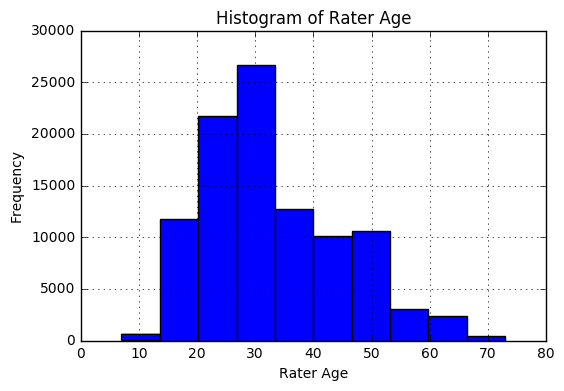

In [50]:
# histogram of age
mr.u_age.hist()
plt.title('Histogram of Rater Age')
plt.xlabel('Rater Age')
plt.ylabel('Frequency')

In [51]:
len(mr)

100000

In [52]:
# Keep the variables to use for Logistic Regression in a new DataFrame

# Variables Removed from Model: 'm_release_year',

log_reg = mr[['r_good_rating',
              'u_male','u_age',
              'm_Action','m_Adventure','m_Animation','m_Children','m_Comedy',
              'm_Crime','m_Documentary','m_Drama','m_Fantasy','m_Film_Noir',
              'm_Horror','m_Musical','m_Mystery','m_Romance','m_Sci-Fi',
              'm_Thriller','m_War','m_Western'
             ]]

# Only Keep records for 1 SEX for each trial
log_reg = log_reg[log_reg['u_male'] == 0]
# Drop SEX variable
log_reg = log_reg.drop('u_male', axis=1)

# Delete records with outliers or missing values
#log_reg = log_reg[log_reg['m_release_year'].isin(['971']) == False]
#log_reg = log_reg[pd.notnull(log_reg['m_release_year'])]

len(log_reg)

25740

##### Create Training and Test sets (20/80 split)

In [53]:
# Predict the y value based on the X values:
if 'r_good_rating' in log_reg:
    y = log_reg['r_good_rating'].values # get the labels we want
    del log_reg['r_good_rating'] # get rid of the class label
    X = log_reg.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames 
    #  they have been converted into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 1000
#num_cv_iterations = 100
num_instances = len(y)
cv_object = ShuffleSplit(n_splits  = num_cv_iterations,
                         test_size = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=1000, random_state=None, test_size=0.2, train_size=None)


#### Logistic Regression

##### Several Iterations were tried to train the model
Average accuracy in 100 CV iterations:
* u_male, u_age, m_release_year, + (All Genre indicators)              Accuracy = 0.5755
It was decided to run Male/Female separately to examine the Weights of Genres with respect to Sex

* (MALE/u_male=1), u_age, m_release_year, + (All Genre indicators)     Accuracy = 0.5801
* (FEMALE/u_male=0), u_age, m_release_year, + (All Genre indicators)   Accuracy = 0.5681
* (FEMALE/u_male=0), m_release_year, + (All Genre indicators)          Accuracy = 0.5664
* (FEMALE/u_male=0), (All Genre indicators)                            Accuracy = 0.5697
* (MALE/u_male=1), (All Genre indicators)                              Accuracy = 0.5778
* (MALE/u_male=1), u_age, m_release_year                               Accuracy = 0.5526

##### Final Models
Average accuracy in 1000 CV iterations:
* (MALE/u_male=1), u_age (All Genre indicators)                        Accuracy = 0.5809
* (FEMALE/u_male=0), u_age (All Genre indicators)                      Accuracy = 0.5697


In [58]:
# Create a reusable logisitic regression object
#    here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
cv_accuracies = []
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # Create new variables here so that it is more obvious what the code is doing
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # Create the accuracy and confusion matrix for this iterations of training/testing
    acc  = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    #print("====Iteration",iter_num," ====")
    #print("accuracy", acc )
    #print("confusion matrix\n",conf)
    iter_num+=1
    cv_accuracies.append(acc)

print ('Average accuracy in ' + str(num_cv_iterations) + ' CV iterations:')
print (sum(cv_accuracies)/len(cv_accuracies))

Average accuracy in 1000 CV iterations:
0.56947979798


#### Weights from Logistic Regression 
Interpret the importance of different features:

* It was decided to split Male and Female into separate models to inspect the Genre weights with the thought that generally Males and Females would prefer different Genres of movies.
* Release Year was modeled just with Age the Weight assigned to Release Year was: -0.0000253. Because of this and negative affect on the accuracy it was dropped from the final model.
* Age in the final models were the lowest weights as expected because they are being multiplied against the User's Age instead of just a 1/0 indicator for the Genre indicators.
    * The suprizing thing was the difference in weights for Age between Male/Female (0.0059/0.0004)
* Genre Indicators are independent of each other because any movie can be in several genres.
    * Some differences in Genres with respect to Sex:
        * Drama (Male/Female) 0.436/0.286
        * Musical (Male/Female) 0.003/0.207
        * Mystery (Male/Female) 0.231/0.084
        * Sci-Fi (Male/Female) 0.214/-0.008

In [59]:
# Review the Weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = log_reg.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

u_age has weight of 0.00167769214047
m_Action has weight of -0.129843835169
m_Adventure has weight of 0.172425344411
m_Animation has weight of 0.469425661084
m_Children has weight of -0.27319902276
m_Comedy has weight of -0.13108171777
m_Crime has weight of 0.0698453269219
m_Documentary has weight of 0.282374534878
m_Drama has weight of 0.318231832412
m_Fantasy has weight of -0.395656661914
m_Film_Noir has weight of 0.537590532711
m_Horror has weight of -0.254543427122
m_Musical has weight of 0.239418711157
m_Mystery has weight of 0.082769502207
m_Romance has weight of 0.233321715321
m_Sci-Fi has weight of 0.0354987730872
m_Thriller has weight of 0.0165178898087
m_War has weight of 0.295290178326
m_Western has weight of 0.231117358197


##### Use another Logistic Regression approach to display ROC Curve

In [60]:
# Keep the variables to use for Logistic Regression in a new DataFrame

# Variables Removed from Model: 'm_release_year',

log_reg2 = mr[['r_good_rating',
               'u_male','u_age',
               'm_Action','m_Adventure','m_Animation','m_Children','m_Comedy',
               'm_Crime','m_Documentary','m_Drama','m_Fantasy','m_Film_Noir',
               'm_Horror','m_Musical','m_Mystery','m_Romance','m_Sci-Fi',
               'm_Thriller','m_War','m_Western'
              ]]

# Only Keep records for 1 SEX for each trial
log_reg2 = log_reg2[log_reg2['u_male'] == 0]
# Drop SEX variable
log_reg2 = log_reg2.drop('u_male', axis=1)

len(log_reg2)

25740

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

y = log_reg2['r_good_rating']
X = log_reg2.drop(['r_good_rating'], axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

# Create a Base Rate Model
def base_rate_model(X):
    y = np.zeros(X.shape[0])
    return y

# Test Base Rate
y_base_rate = base_rate_model(X_test)

print("Base rate accuracy is %2.4f" % accuracy_score(y_test, y_base_rate))

Base rate accuracy is 0.4404


C:\Users\runni\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [64]:
model2 = LogisticRegression(penalty='l2', C=1.0)

model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### Second Logistic Regression Method 
* (MALE/u_male=1), u_age (All Genre indicators)      Base Rate: 0.4528 / Accuracy = 0.5782
* (FEMALE/u_male=0), u_age (All Genre indicators)    Base Rate: 0.4528 / Accuracy = 0.5782

In [67]:
print("Logistic Regression Model2 Accuracy is %2.4f" % accuracy_score(y_test, model2.predict(X_test)))

Logistic Regression Model2 Accuracy is 0.5703


In [68]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

model2_roc_auc = roc_auc_score(y_test, model2.predict(X_test))
print("Logistic AUC = %2.2f" % model2_roc_auc)
print(classification_report(y_test, model2.predict(X_test)))

Logistic AUC = 0.54
             precision    recall  f1-score   support

          0       0.52      0.31      0.39      2267
          1       0.59      0.77      0.67      2881

avg / total       0.56      0.57      0.55      5148



##### ROC Results from Logistic Regression 2 model
The second method produced generally the same accuracy rate but we captured the Base Rate for a comparison point. 
The ROC Curve shows that the model does not perform very well as we want to get as close to the upper-left corner as possible.

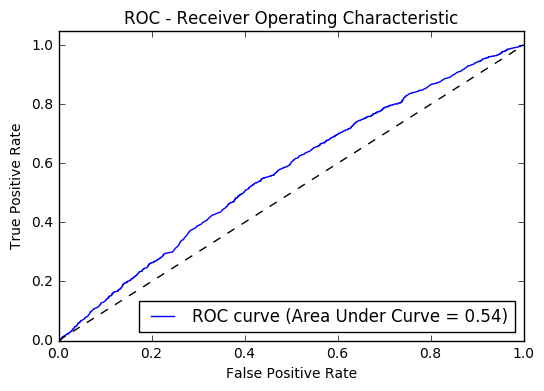

In [69]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, model2.predict_proba(X_test)[:,1])

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (Area Under Curve = %2.2f)' % model2_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()







# Support Vector Machines

In [73]:
# We will use the same train and test validations used in the logistic regression for our support vector
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [79]:
from sklearn.svm import SVC

#train the model
svm_clf = SVC(C=0.5, kernel='rbf', degree = 3, gamma='auto')
svm_clf.fit(X_train_scaled, y_train) # fit the object for training data

y_hat = svm_clf.predict(X_test_scaled) # predictions of y using the test data

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('Accuracy of Model: ', acc)
print(conf)

Accuracy of Model:  0.588578088578
[[ 749 1518]
 [ 600 2281]]


In [81]:
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_)

(17084, 19)
(17084,)
[8489 8595]


In [104]:
mr_train = mr.iloc[train_indices]
mr_support = rm_train.iloc[svm_clf.support_,:]

mr_support['r_good_rating'] = y[svm_clf.support_]
mr['r_good_rating'] = y

mr_support['u_male'] = pd.to_numeric(mr_support['u_male'], errors='coerce')
mr_support.type()
mr_support.info()

C:\Users\runni\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\runni\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AttributeError: 'DataFrame' object has no attribute 'type'

C:\Users\runni\Anaconda3\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support 'B' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
C:\Users\runni\Anaconda3\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
C:\Users\runni\Anaconda3\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support 'd' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
C:\Users\runni\Anaconda3\lib\site-packages\matplotlib\legend.py:633: UserWarning: Legend does not support '_' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/use

LinAlgError: singular matrix

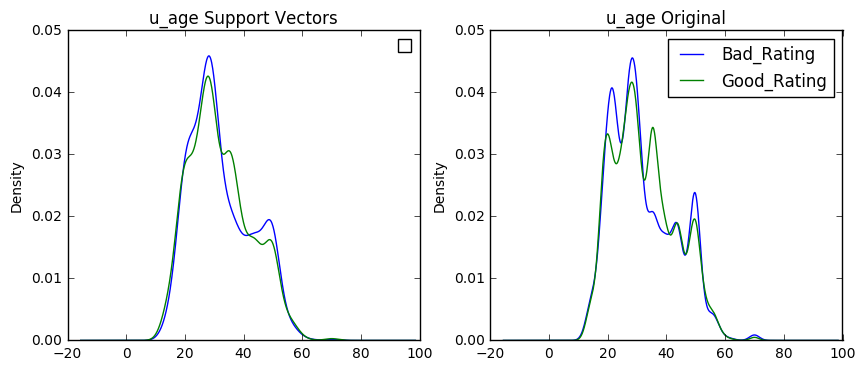

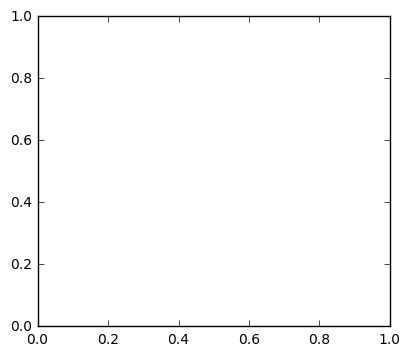

In [101]:
from pandas.tools.plotting import boxplot

mr_grouped_support = mr_support.groupby(['r_good_rating'])
mr_grouped = mr.groupby(['r_good_rating'])

# what variables we will plot
plot_vars = ['u_age','u_male','m_days_to_video']

for v in plot_vars:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    ax = mr_grouped_support[v].plot.kde()
    plt.legend('Bad_Rating','Good_Rating')
    plt.title(v+' Support Vectors')
    
    plt.subplot(1,2,2)
    ax = mr_grouped[v].plot.kde()
    plt.legend(['Bad_Rating','Good_Rating'])
    plt.title(v+' Original')
